# Mask R-CNN - Inspect Training Data

Inspect and visualize data loading and pre-processing code.

In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline

Using TensorFlow backend.


## Configurations

Run one of the code blocks below to import and load the configurations to use.

In [2]:
import nova_basic
config = nova_basic.novaConfig()

## Dataset

In [3]:
# Load dataset
dataset = nova_basic.novaDataset()
dataset.load_nova('../data/sample/','eval')
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Loaded 20 images from eval data.
Image Count: 20
Class Count: 9
  0. BG                                                
  1. Electron                                          
  2. Muon                                              
  3. Proton                                            
  4. Neutron                                           
  5. Pion                                              
  6. Pi0                                               
  7. Photon                                            
  8. Other                                             


## Display Samples

Load and display images and masks.

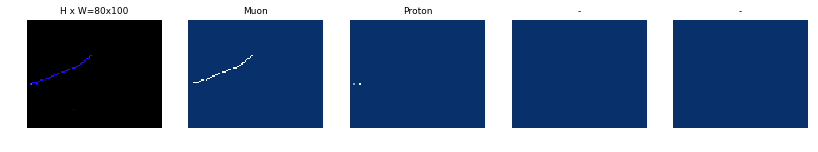

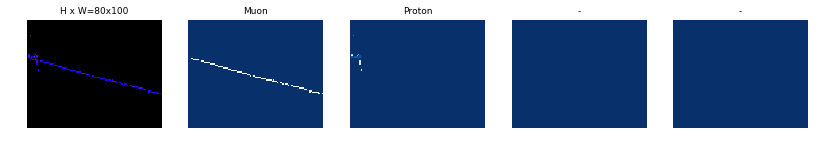

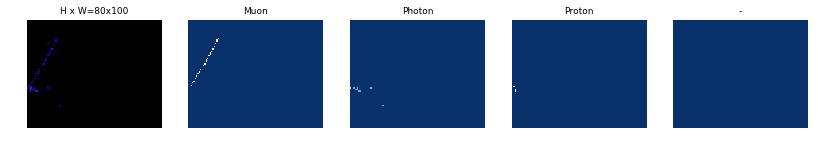

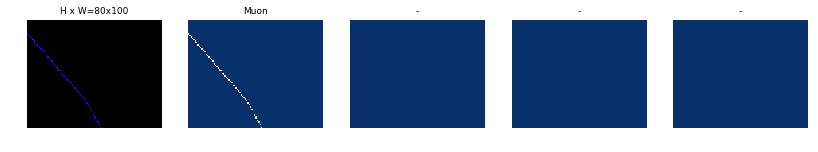

In [4]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bounding Boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

image_id  18 
image                    shape: (80, 100, 3)          min:    0.00000  max:  255.00000  uint8
mask                     shape: (80, 100, 8)          min:    0.00000  max:    1.00000  bool
class_ids                shape: (8,)                  min:    2.00000  max:    8.00000  int32
bbox                     shape: (8, 4)                min:    0.00000  max:   54.00000  int32


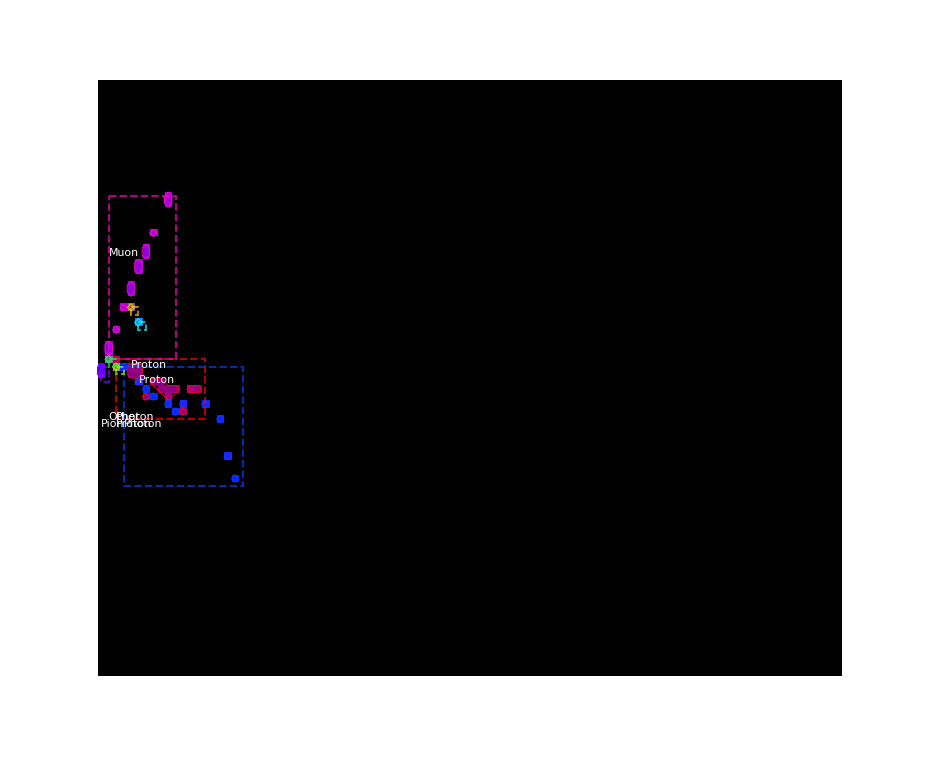

In [5]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors

The order of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

**Anchor Stride:**
In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature meap of the first layer is 256x256, which generates about 200K anchors (256*256*3). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example. 

In this implementation we use an anchor stride of 2, which is different from the paper.

In [6]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  4092
Scales:  (4, 8, 16, 32, 64)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 3072
Anchors in Level 1: 768
Anchors in Level 2: 192
Anchors in Level 3: 48
Anchors in Level 4: 12


Visualize anchors of one cell at the center of the feature map of a specific level.

Level 0. Anchors:   3072  Feature map Shape: [32 32]
Level 1. Anchors:    768  Feature map Shape: [16 16]
Level 2. Anchors:    192  Feature map Shape: [8 8]
Level 3. Anchors:     48  Feature map Shape: [4 4]
Level 4. Anchors:     12  Feature map Shape: [2 2]


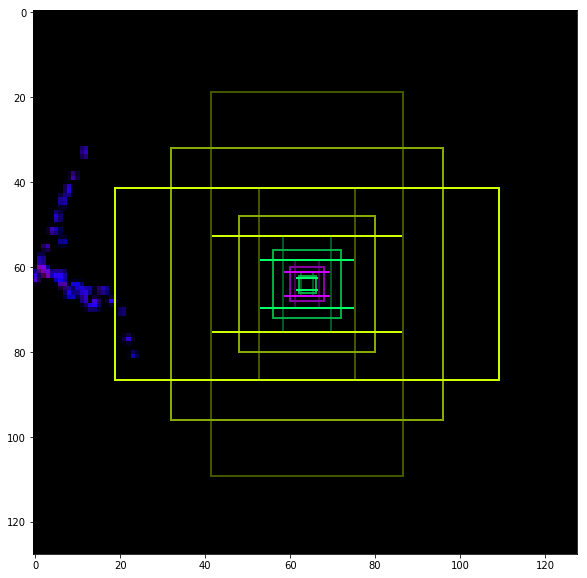

In [7]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator


In [8]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [9]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 50, 4)            min:    0.00000  max:  127.00000  int32
mrcnn_class_ids          shape: (4, 50, 1)            min:    0.00000  max:    7.00000  int32
mrcnn_bbox               shape: (4, 50, 9, 4)         min:   -3.33333  max:    2.55413  float32
mrcnn_mask               shape: (4, 50, 28, 28, 9)    min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 100)              min:    0.00000  max:    7.00000  int32
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max:  113.00000  int32
gt_masks                 shape: (4, 128, 128, 100)    min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 4092, 1)          min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:   -8.66434  max:    4.58145  float64
image_id:  3 


anchors                  shape: (4092, 4)             min:  -45.25483  max:  126.82843  float64
refined_anchors          shape: (3, 4)                min:    0.00000  max:   81.00000  float32
Positive anchors: 3
Negative anchors: 253
Neutral anchors: 3836
BG                     : 34
Proton                 : 16


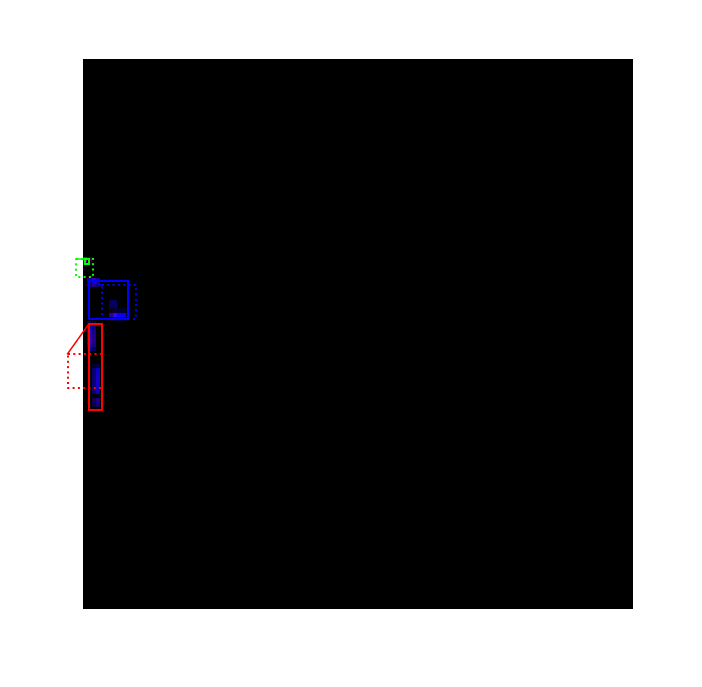

In [13]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors)

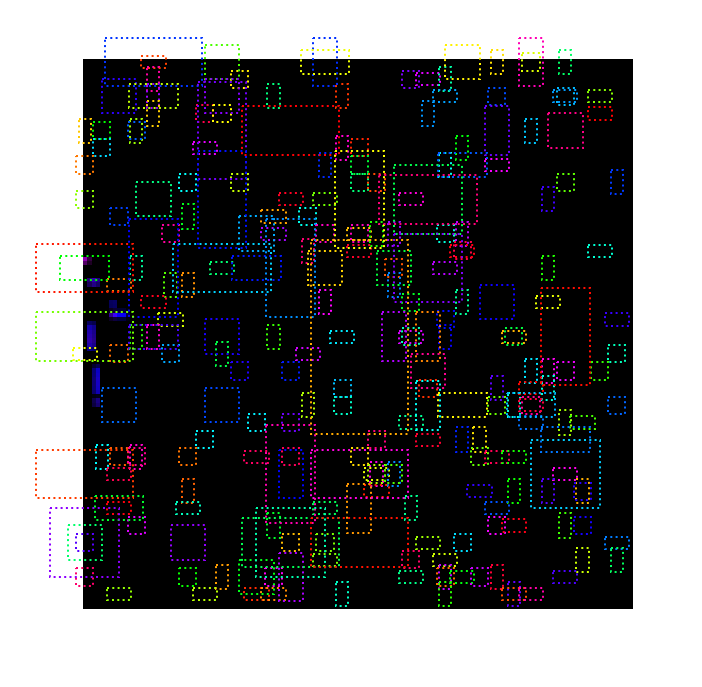

In [14]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

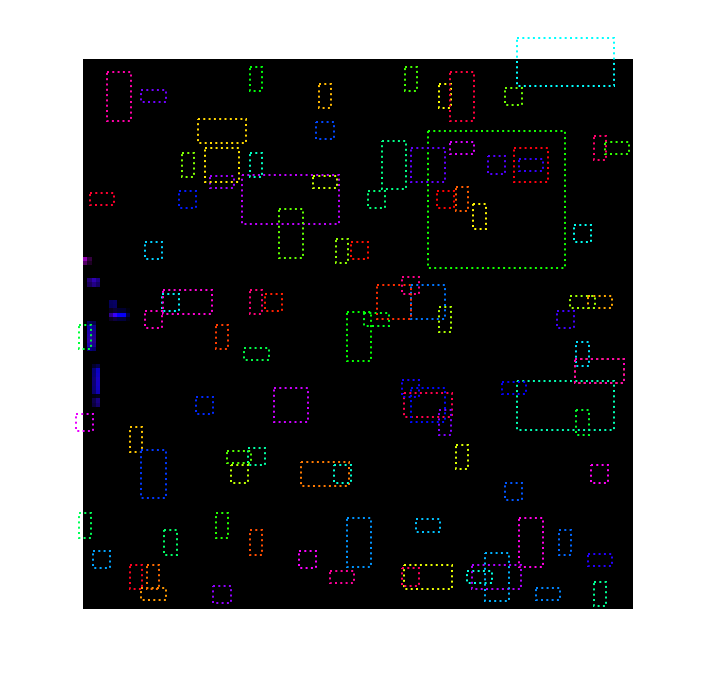

In [15]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Positive ROIs:  16
Negative ROIs:  34
Positive Ratio: 0.32
Unique ROIs: 32 out of 50


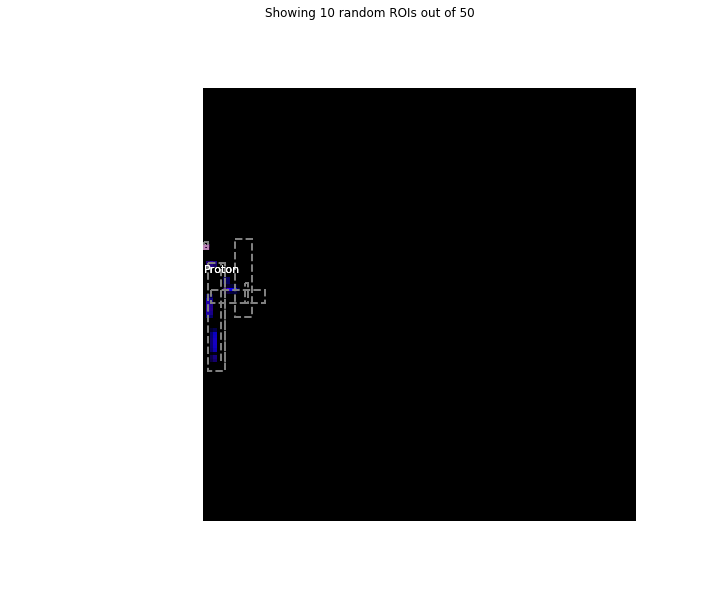

In [16]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

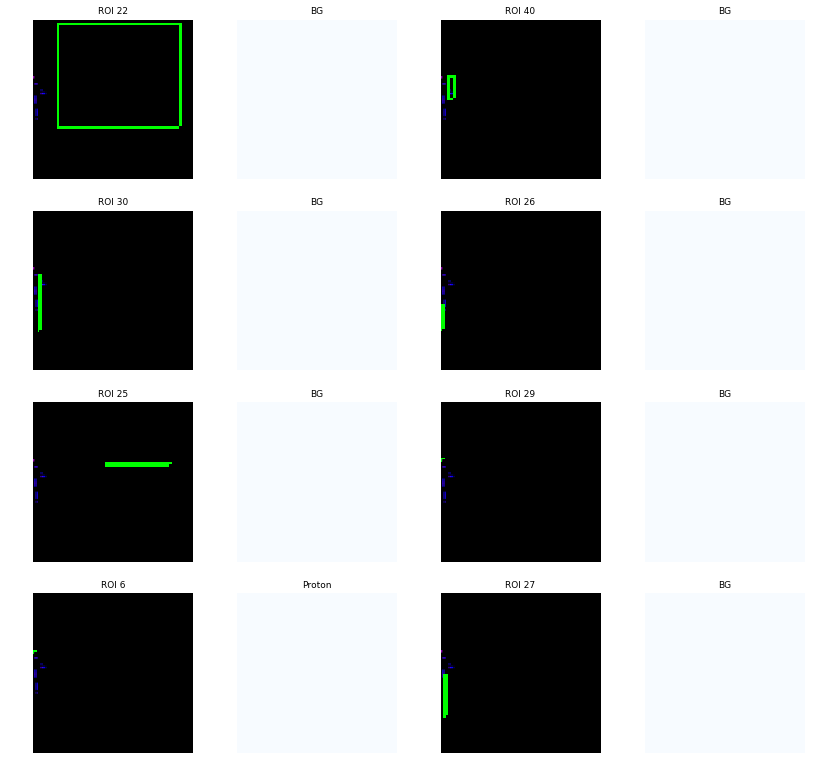

In [17]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [19]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   16  0.32
   16  0.32
   16  0.32
   16  0.32
   16  0.32
   16  0.32
   16  0.32
   16  0.32
   16  0.32
   16  0.32
Average percent: 0.32
